In [528]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import datetime
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import random
import time
from scipy.interpolate import interp1d
import math

In [529]:
def open_datacube(directory):
    with xr.open_dataset(directory, decode_timedelta=False) as ds:
        data = ds
    return data

In [530]:
greenland_dir = 'data/Greenland_61.6N_48.1W.nc'
gl_cube = open_datacube(greenland_dir)

In [532]:
sorted_cube = gl_cube.sortby('acquisition_img2') # sort by date of first image taken
# sorted_cube2 = gl_cube.sortby('mid_date')

In [533]:
x_coord = 192 # x coord of grid cell
y_coord = 219 # y coord of grid cell

In [536]:
v = sorted_cube.v
x = sorted_cube.x
y = sorted_cube.y
mid_dates = sorted_cube.mid_date
im1 = sorted_cube.acquisition_img2
im2 = sorted_cube.acquisition_img1
dts = sorted_cube.date_dt
v_error = np.sqrt(sorted_cube.vx_error**2 + sorted_cube.vy_error**2)
dyr = dts/365.25

In [540]:
# velocities of a specific grid cell in the cube
cell = sorted_cube.v.isel(x=x_coord, y=y_coord)
cell = cell.where(cell.mid_date > np.datetime64("2000")) # only use data from 2000 or later

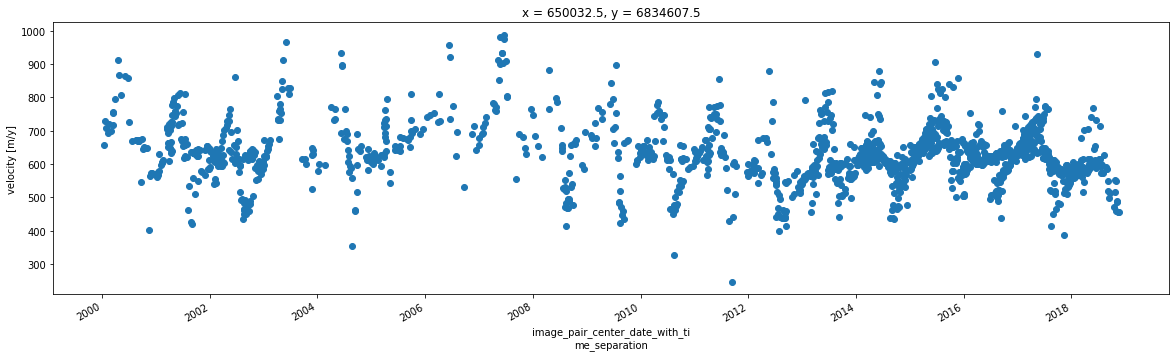

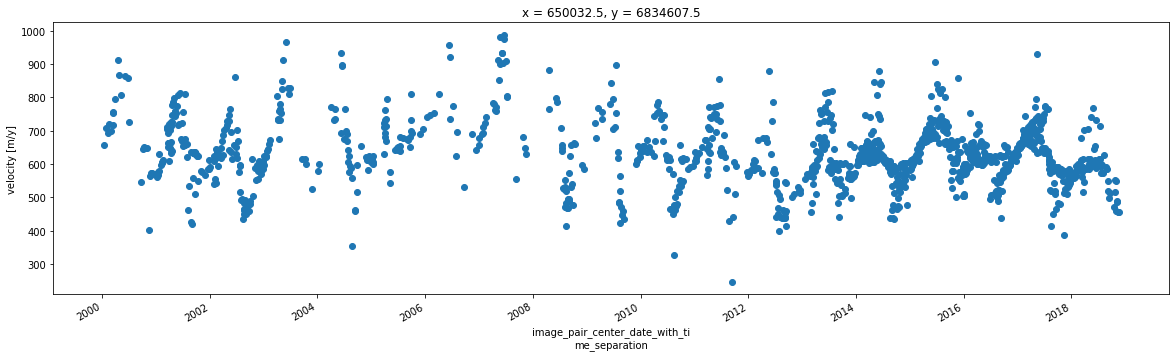

In [542]:
# remove outliers
threshold = 2.5 * 1.4826 * v_error
upper_threshold = cell.median(dim='mid_date', skipna=True) + threshold
lower_threshold = cell.median(dim='mid_date', skipna=True) - threshold
mask = cell <= upper_threshold
mask = cell >= lower_threshold

cell = cell[mask]
mid_dates_cell = mid_dates[mask]
dts_cell = dts[mask]
dyr_cell = dyr[mask]
v_error_cell = v_error[mask]

# convert image dates to integers, with 0 being the earliest date of an image taken (units are days, ex: 23 and 25 are two days apart)
im1_cell = np.array(list(map(datetime.date.toordinal, im1.values[mask].astype('M8[D]').astype('O'))))
scale = min(im1_cell)
im1_cell -= scale
im2_cell = np.array(list(map(datetime.date.toordinal, im2.values[mask].astype('M8[D]').astype('O'))))
im2_cell -= scale

cell.plot(marker='o', linestyle='None', figsize=(20,5))
plt.show()

# filter out image pairs with dts longer than a year
short_dt_cell = cell.where(dts_cell < 365)
short_dt_cell.plot(marker='o', linestyle='None', figsize=(20,5))
plt.show()

In [579]:
# make a continuous time range
times = np.array(list(map(datetime.date.toordinal, cell.mid_date.values.astype('M8[ms]').astype('O'))))
TIMES = np.array(range(min(times), max(times)+1))
DATES = np.array(list(map(datetime.date.fromordinal, TIMES)))

min_date = min(mid_dates_cell).values.astype('M8[ms]').astype('O').year
max_date = max(mid_dates_cell).values.astype('M8[ms]').astype('O').year

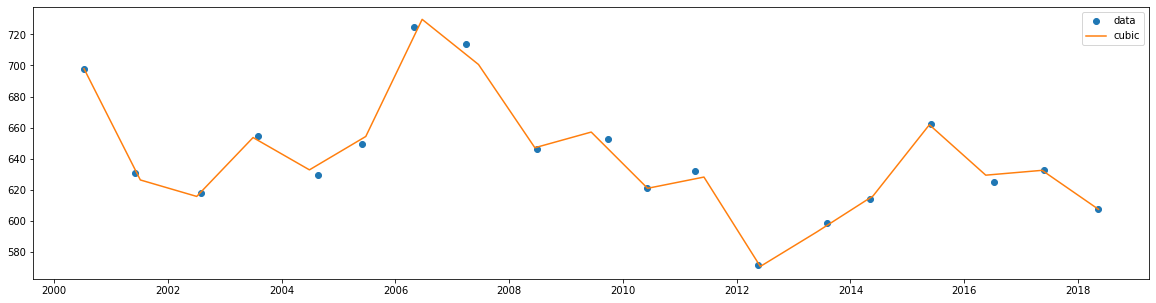

In [544]:
# REMOVING INTERANNUAL VARIABILITY

# calculate the weighted mean velocities
weighted_vels = []
weighted_dates = []
cell_years = []
for year in range(min_date, max_date+1):
    cell_years.append(year)
    cell_year = cell.where(cell.mid_date >= np.datetime64(year, 'Y')-1970).where(cell.mid_date < np.datetime64(year+1, 'Y')-1970) 
    year_mask = np.isfinite(cell_year)
    cell_year = cell_year[year_mask]
    v_error_year = v_error_cell[year_mask]
    
    first = datetime.date(year, 1, 1).toordinal()
    mid_dates_year = mid_dates_cell[year_mask].values.astype('M8[ms]').astype('O')
    mid_dates_year = np.array(list(map(datetime.date.toordinal, mid_dates_year))) - first
    weights = 1/v_error_year**2

    weighted_cell = weights/sum(weights)*cell_year
    weighted_vels.append(sum(weighted_cell.values))
    
    weighted_date = weights/sum(weights)*mid_dates_year
    weighted_dates.append(sum(weighted_date.values)+first)
    
cell_years = np.array(cell_years)
weighted_vels = np.array(weighted_vels)
weighted_dates_ord = np.array(weighted_dates)
weighted_dates = list(map(datetime.date.fromordinal, weighted_dates_ord.astype(int)))

# interpolate a spline fit
FIRST = min(weighted_dates_ord)
LAST = max(weighted_dates_ord)
f = interp1d(weighted_dates_ord, weighted_vels, kind='cubic')
xnew = np.linspace(FIRST, LAST, num=len(cell_years), endpoint=True)
plt.figure(figsize=(20,5))
plt.plot(weighted_dates, weighted_vels, 'o', xnew, f(xnew), '-')
plt.legend(['data', 'cubic'], loc='best')
plt.show()

ia_var = f(xnew)

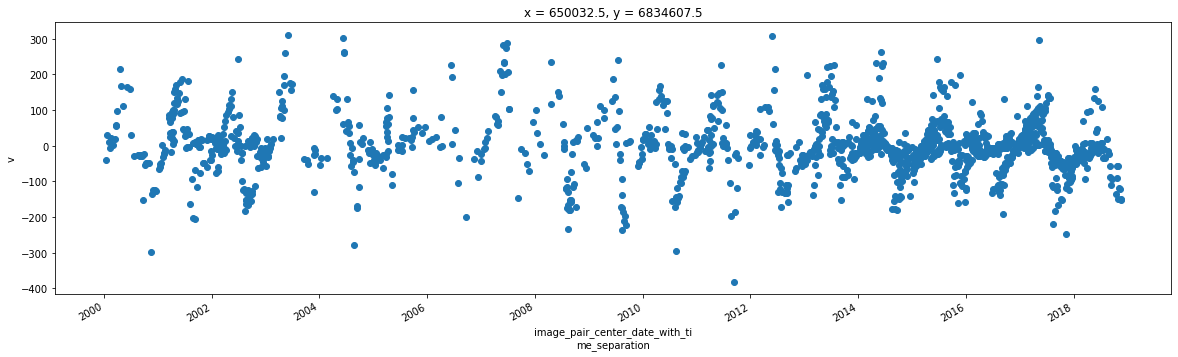

In [595]:
# remove the interannual variability from the velocities
removed = None

for year in range(min_date, max_date+1):
    cell_year = cell.where(cell.mid_date >= np.datetime64(year, 'Y')-1970).where(cell.mid_date < np.datetime64(year+1, 'Y')-1970) 
    year_mask = np.isfinite(cell_year)
    cell_year = cell_year[year_mask]
    index = year - cell_years[0]
    removed_ia_var = cell_year - ia_var[index]

    if year == min_date:
        removed = removed_ia_var
    else:
        removed = xr.concat([removed, removed_ia_var], 'mid_date')
# removed = removed.where(dts_cell < 365)
rem_mask = dts_cell < 365
removed.plot(marker='o', linestyle="None", figsize=(20, 5))
plt.show()

In [558]:
w_d = 1/(v_error_cell * dyr_cell)**2

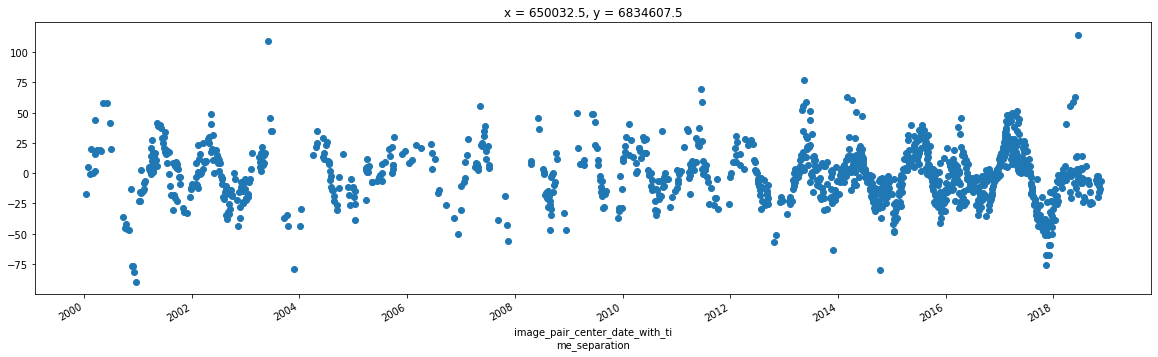

In [562]:
# calculate the displacement of each image pair (not cumulative displacement)
disp_rem = dyr_cell * removed
disp_rem = disp_rem[rem_mask]
im1_rem = im1_cell[rem_mask]
im2_rem = im2_cell[rem_mask]
disp_rem.plot(marker='o', linestyle='None', figsize=(20,5))
plt.show()

In [560]:
# disp = np.zeros(max(im2_cell))
# for date in range(max(im2_cell)):
#     ranges = []
#     for index in range(len(im1_cell)):
#         if date >= im1_cell[index] and date <= im2_cell[index]:
#             if not np.isnan(removed.values[index]):
#                 ranges.append(index)
#     if not ranges:
#         if date != 0:  
#             disp[date] = disp[date-1]
#     elif date == 0:
#         if not np.isnan(removed.values[index]):
#             disp[date] = removed.values[index]
#     elif len(ranges) == 1:
# #         print(date, (removed.values[index]/dts_cell.values[index]))
#         disp[date] = disp[date-1] + (removed.values[index]/dts_cell.values[index])
# #     print(date, ranges)
# #     print(disp[date])

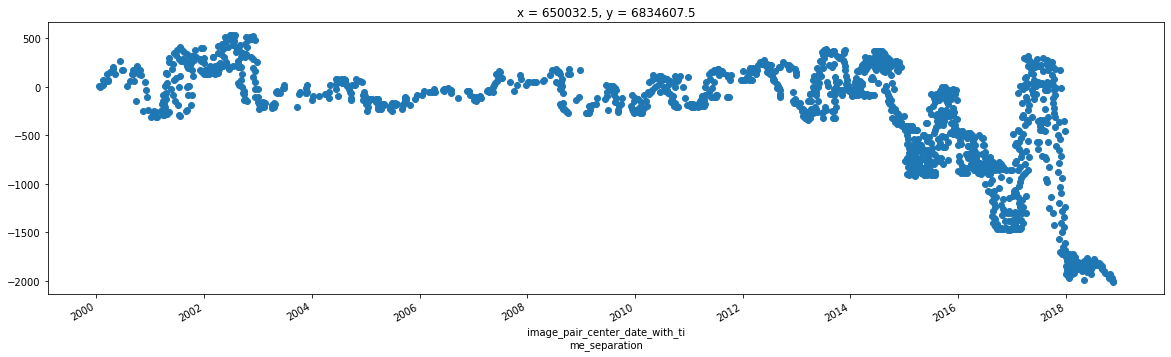

In [565]:
# cumulative displacement
cum_disp_rem = np.cumsum(removed * dyr_cell)
cum_disp_rem.plot(marker='o', linestyle='None', figsize=(20,5))
plt.show()

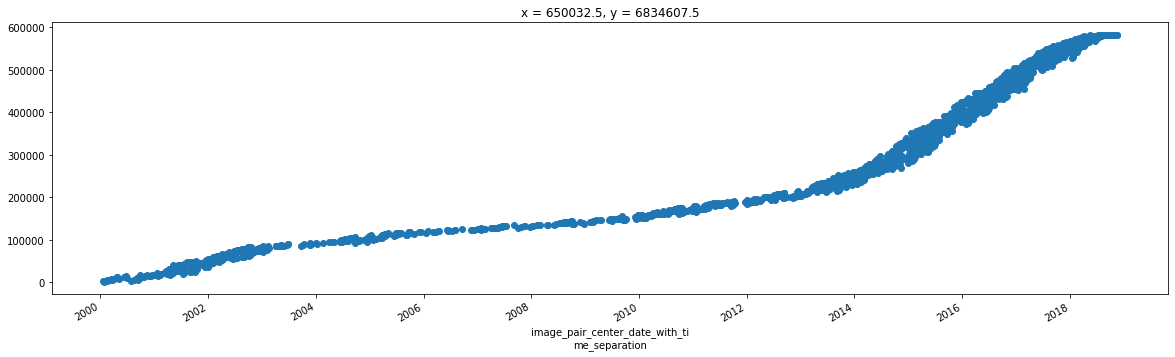

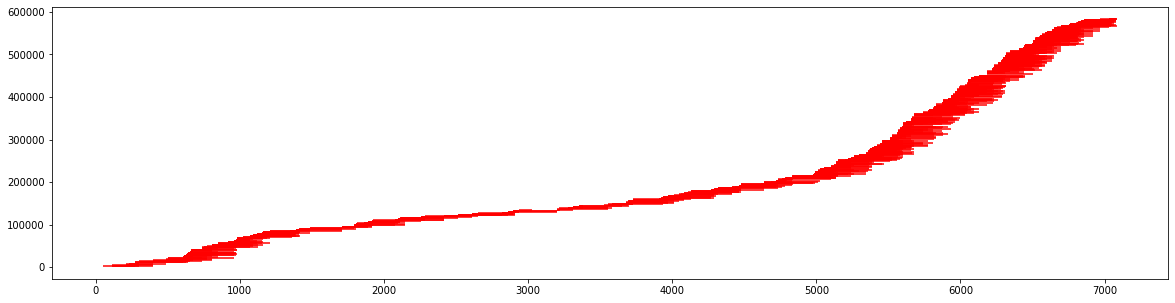

In [566]:
# cumulative displacement without removing interannual variability
cum_disp = np.cumsum(cell/365.25 * dts_cell)
cum_disp.plot(marker='o', linestyle='None', figsize=(20,5))
short_dts = dts_cell < 365
plt.figure(figsize=(20,5))
plt.hlines(cum_disp.values[short_dts], im1_cell[short_dts], im2_cell[short_dts], color='red')
plt.show()

In [567]:
T = 1

In [568]:
def displacement(t, c1, c2):
    t1, t2 = t
    return c1*T/(2*np.pi) * (np.cos(2*np.pi*t1/T) - np.cos(2*np.pi*t2/T)) + c2*T/(2*np.pi) * (np.sin(2*np.pi*t2/T) - np.sin(2*np.pi*t1/T))
#     return c1*T/(2*np.pi) * (np.cos(2*np.pi*t1/T) - np.cos(2*np.pi*t2/T)) + c2*T/(2*np.pi) * (np.sin(2*np.pi*t2/T) - np.sin(2*np.pi*t1/T)) + c0*(t2-t1)

In [569]:
param, param_cov = curve_fit(displacement, [im1_cell, im2_cell], disp)

/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [570]:
param_rem, param_cov = curve_fit(displacement, [im1_rem/365.25, im2_rem/365.25], disp_rem, sigma = w_d[rem_mask])

In [575]:
c1, c2 = param_rem
a = np.sqrt(c1**2+c2**2)
ph_rad = math.atan2(c2, c1)
ph = 365.25*(0.25 - ph_rad/(2*np.pi) % 1)
print(f"Amplitude: {a}, Phase: {ph}")

Amplitude: 123.46349272270176, Phase: -79.12646232363821


In [576]:
def velocity(t, a, ph):
#     t1, t2 = t
#     return a * T/(2*np.pi*(t2-t1))*(np.cos(2*np.pi*(t2+ph)/T) - np.cos(2*np.pi*(t1+ph)/T))
    return a * np.sin(2*np.pi*(t+ph)/T)

In [580]:
# vels = velocity([im1_cell, im2_cell], a, ph)
vels = velocity(TIMES/365.25, a, ph)

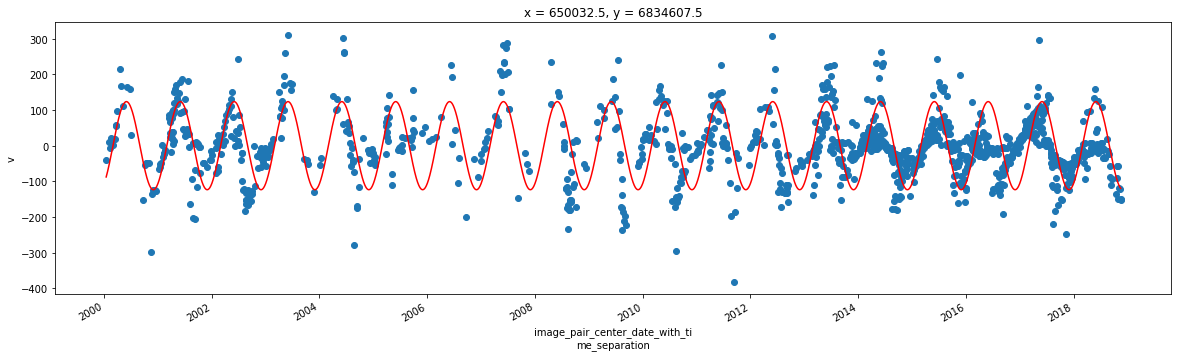

In [591]:
plt.figure(figsize=(20,5))
removed.plot(marker='o', linestyle="None")
plt.plot(DATES, vels, color='r')
plt.show()

In [582]:
t = [im1_cell/365.25, im2_cell/365.25]
pred_disp = displacement(t, c1, c2)

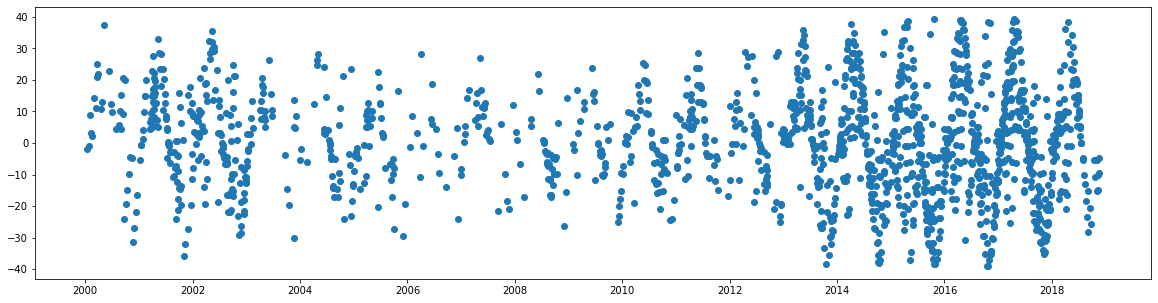

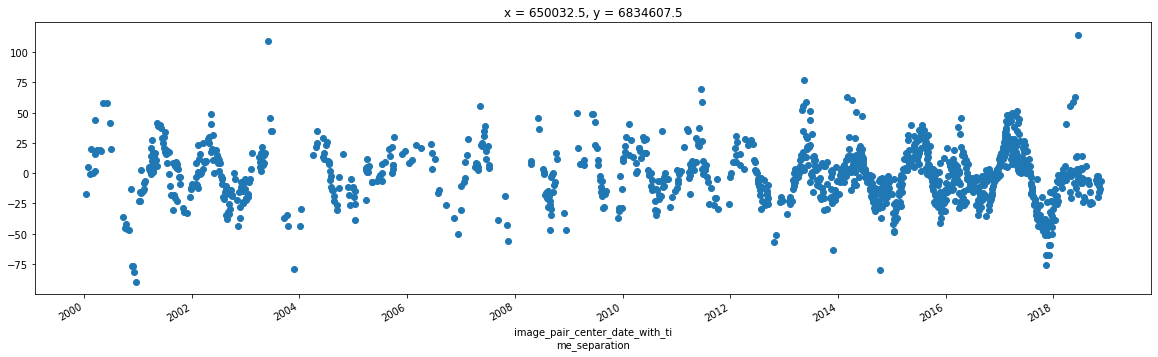

In [583]:
plt.figure(figsize=(20,5))
plt.scatter(mid_dates_cell, pred_disp)
disp_rem.plot(marker='o', linestyle='None', figsize=(20,5))

In [585]:
def disp_t(t, a, ph):
    return T/(2*np.pi)*a*np.cos(2*np.pi/T*(t+ph))

In [589]:
pred_disp = disp_t(TIMES/365.25, a, ph)

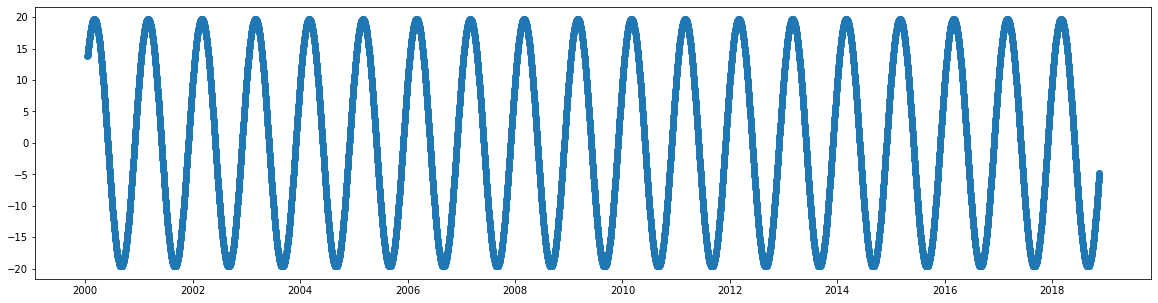

In [590]:
plt.figure(figsize=(20,5))
plt.scatter(DATES, pred_disp)